In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import gudhi as gd
from scipy.spatial.distance import hamming
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio


In [2]:
# Let's assume that "population" is a numpy ndarray with your genomes as rows.
def calculate_hamming_matrix(population):
    # Number of genomes
    num_genomes = population.shape[0]
    # Create an empty matrix for Hamming distances
    hamming_matrix = np.zeros((num_genomes, num_genomes), dtype=int)
   # Calculate the Hamming distance between each pair of genomes
    for i in range(num_genomes):
        for j in range(i+1, num_genomes):  # j=i+1 to avoid calculating the same distance twice
            # The Hamming distance is multiplied by the number of genes to convert it into an absolute distance
            distance = hamming(population[i], population[j]) * num_genes
            hamming_matrix[i, j] = distance
            hamming_matrix[j, i] = distance  # The matrix is symmetric
    
    return hamming_matrix

In [3]:
def create_complex(distance_matrix):
    # Create the Rips simplicial complex from the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix)
    # Create the simplex tree from the Rips complex with a maximum dimension of 3
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
    # Compute the persistence of the simplicial complex
    persistence = simplex_tree.persistence()
    # Return the persistence diagram or barcode
    return persistence, simplex_tree


In [4]:
import numpy as np

def mutate(genome, prob, mutated_positions):
    """Performs mutations on a genome with a certain probability."""
    mutations = []
    for i in range(len(genome)):
        if not mutated_positions[i] and np.random.rand() < prob:
            genome[i] = 1 if genome[i] == 0 else 0
            mutations.append(i)
            mutated_positions[i] = True
    return genome, mutations

def create_generation(population, num_offspring, prob, mutated_positions):
    """Creates a new generation from the existing population."""
    new_population = []
    new_generation_history = []
    for idx, genome in enumerate(population):
        for _ in range(num_offspring):
            new_genome, mutations = mutate(genome.copy(), prob, mutated_positions)
            new_population.append(new_genome)
            new_generation_history.append({'parent': idx, 'mutations': mutations})
    return new_population, new_generation_history

def create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones,semilla):
    np.random.seed(semilla)

    initial_genome = np.random.choice([0, 1], size=num_genes, p=[1-percentage_ones, percentage_ones])
    population = [initial_genome]
    genome_history = []
    global_mutated_positions = np.zeros(num_genes, dtype=bool)

    for generation in range(num_generations):
        population, generation_history = create_generation(population, num_offspring, mutation_probability, global_mutated_positions)
        genome_history.extend(generation_history)
        print(f"Generation {generation+1}: {len(population)} genomes")
        # Uncomment the next line if you want to see the details of each generation
        # print(len(population), generation_history)

    return population, genome_history

In [5]:
def modify_genomes(population, num_groups, group_size, num_positions_to_change):
    np.random.seed(42)  # Puedes usar cualquier número como semilla

    # Crear una copia de la población para evitar modificar el original
    modified_population = population.copy()

    for _ in range(num_groups):
        # Seleccionar genomas de manera aleatoria
        genome_indices = np.random.choice(population.shape[0], group_size, replace=False)
        
        # Elegir un punto de inicio al azar y seleccionar posiciones contiguas para cambiar
        start_position = np.random.choice(population.shape[1] - num_positions_to_change)
        positions_to_change = np.arange(start_position, start_position + num_positions_to_change)
        
        for index in genome_indices:
            # Cambiar los valores en las posiciones seleccionadas a 1
            modified_population[index, positions_to_change] = 1
    
    return modified_population

In [6]:
def calculate_persistence_and_average(input_list):
    # Filter tuples with a 1 in the first position
    filtered = [tuple for tuple in input_list if tuple[0] == 1]

    # Calculate persistence for each filtered tuple
    persistences = [abs(tuple[1][1] - tuple[1][0]) for tuple in filtered]

    # Calculate the average of these persistences
    average_persistence = sum(persistences) / len(persistences) if persistences else 0

    return filtered, persistences, average_persistence

In [7]:
def analyze_population(population, num_groups, group_size, num_positions):
    # Modify genomes with the new num_groups parameter
    population_modified = modify_genomes(population, num_groups=num_groups, group_size=group_size, num_positions_to_change=num_positions)

    # Calculate the Hamming matrix
    hamming_matrix = calculate_hamming_matrix(population_modified)

    # Perform persistent homology
    persistence, simplex_tree = create_complex(hamming_matrix)

    # Calculate persistence and average
    filtered, persistences, average_persistence = calculate_persistence_and_average(persistence)

    # Return number of 1-holes and their persistences
    return len(filtered), persistences

In [8]:
def process_seed(seed, num_genes, mutation_probability, num_generations, num_offspring, percentage_ones):
    print(f"Procesando semilla {seed}...")
    population, population_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones, seed)
    population = np.array(population)
    num_1_holes_list = []
    average_persistences = []
    num_positions_changes = range(1, 100)
    for num in num_positions_changes:
        num_1_holes, persistences = analyze_population(population, 1, 3, num)
        num_1_holes_list.append(num_1_holes)
        average_persistences.append(sum(persistences) / len(persistences) if persistences else 0)
    return num_1_holes_list, average_persistences, population

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Definir parámetros iniciales
# num_genes = 505
# mutation_probability = 1 / num_genes
# num_generations = 7
# num_offspring = 2
# percentage_ones = 0.25
# seeds_range = range(1, 99)  # Por ejemplo, de 40 a 41

# # Diccionario para almacenar los datos de todos los experimentos
# experiments_results = {}

# # Acumuladores para las estadísticas a graficar
# total_num_1_holes = [[] for _ in range(99)]  # 99 porque range(1,100) tiene 99 elementos
# total_persistences = [[] for _ in range(99)]

# # Procesar cada semilla
# for seed in seeds_range:
#     num_1_holes_list, average_persistences, population = process_seed(seed, num_genes, mutation_probability, num_generations, num_offspring, percentage_ones)
    
#     # Agregar los resultados a los acumuladores
#     for i in range(99):
#         total_num_1_holes[i].append(num_1_holes_list[i])
#         total_persistences[i].append(average_persistences[i])

#     experiments_results[seed] = {
#         'seed': seed,
#         'num_1_holes_list': num_1_holes_list,
#         'average_persistences': average_persistences,
#         'population': population
#     }




In [ ]:
len(experiments_results[1]['num_1_holes_list'])


In [ ]:
len(total_num_1_holes)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suponemos que experiments_results ya está definido con todos los datos.

# Número de tamaños de transferencia
transfer_size_count = 99  # De 0 a 99

# Inicializamos listas para acumular los datos
total_1_holes = [0] * transfer_size_count
total_persistences = [0] * transfer_size_count
count_seeds = len(experiments_results)

# Sumar los valores para cada tamaño de transferencia de todas las semillas
for seed_data in experiments_results.values():
    num_1_holes_list = seed_data['num_1_holes_list']
    average_persistences = seed_data['average_persistences']
    for i in range(transfer_size_count):
        total_1_holes[i] += num_1_holes_list[i]
        total_persistences[i] += average_persistences[i]

# Calcular las medias
average_1_holes = [total / count_seeds for total in total_1_holes]
average_persistences = [total / count_seeds for total in total_persistences]

# Graficar los resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(transfer_size_count), average_1_holes, marker='o')
plt.title('Media de Num 1 Holes por Tamaño de Transferencia')
plt.xlabel('Tamaño de Transferencia')
plt.ylabel('Media de Num 1 Holes')

plt.subplot(1, 2, 2)
plt.plot(range(transfer_size_count), average_persistences, marker='o')
plt.title('Media de Persistencias por Tamaño de Transferencia')
plt.xlabel('Tamaño de Transferencia')
plt.ylabel('Media de Persistencias')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suponemos que experiments_results ya está definido con todos los datos.

# Número de tamaños de transferencia
transfer_size_count = 99  # De 0 a 99

# Crear una lista de listas para los valores de num_1_holes para cada tamaño de transferencia
holes_data_by_transfer_size = [[] for _ in range(transfer_size_count)]

# Llenar la lista con los datos de cada semilla
for seed_data in experiments_results.values():
    num_1_holes_list = seed_data['num_1_holes_list']
    for i in range(transfer_size_count):
        holes_data_by_transfer_size[i].append(num_1_holes_list[i])

# Convertir a array de numpy para fácil manejo
holes_data_by_transfer_size = [np.array(data) for data in holes_data_by_transfer_size]


In [ ]:
# Configuración de la figura
plt.figure(figsize=(20, 10))

# Crear el boxplot
sns.boxplot(data=holes_data_by_transfer_size)

# Añadir títulos y etiquetas
plt.title('Distribución de Num 1 Holes por Tamaño de Transferencia')
plt.xlabel('Tamaño de Transferencia')
plt.ylabel('Num 1 Holes')
plt.xticks(range(transfer_size_count), range(transfer_size_count))  # Etiquetas para cada tamaño de transferencia

# Mostrar el gráfico
plt.show()


In [ ]:
# import pickle


# # Guardar el diccionario con pickle
# with open('datos.pkl', 'wb') as archivo:
#     pickle.dump(experiments_results, archivo)


In [11]:
import pickle

# Cargar el diccionario desde un archivo pickle
with open('datos.pkl', 'rb') as archivo:
    diccionario_cargado = pickle.load(archivo)

print(diccionario_cargado)

{1: {'seed': 1, 'num_1_holes_list': [0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'average_persistences': [0, 0, 0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.5, 5.5, 5.5, 5.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'population': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 

In [12]:
experiments_results=diccionario_cargado


In [72]:
import pandas as pd

# Preparar datos para el DataFrame de average_persistences
average_persistences_data = []
num_1_holes_data = []

for seed in range(1, 99):  # Asumiendo que los seeds son de 1 a 99
    average_persistences_data.append(experiments_results[seed]['average_persistences'])
    num_1_holes_data.append(experiments_results[seed]['num_1_holes_list'])

# Crear DataFrames
df_average_persistences = pd.DataFrame(average_persistences_data, index=range(1, 99))
df_num_1_holes = pd.DataFrame(num_1_holes_data, index=range(1, 99))

gene_gain_sizes = range(1, 100)  # Asumiendo que hay 99 tamaños de ganancia de genes

df_average_persistences.columns = [f'Gain Size {size}' for size in gene_gain_sizes]
df_num_1_holes.columns = [f'Gain Size {size}' for size in gene_gain_sizes]

In [ ]:
std_dev_persistences = list(df_average_persistences.std())
std_dev_persistences

In [42]:
std_dev_holes = list(df_num_1_holes.std())


In [73]:
import numpy as np

# Suponiendo que tenemos un diccionario de resultados llamado `experiments_results`
# Inicializar un arreglo para sumar las persistencias y contar cuántos valores sumamos
sum_persistences = np.zeros(99)
count_persistences = np.zeros(99)

for seed in range(1, 98):  # Asumiendo que seed va de 1 a 99
    average_persistences = experiments_results[seed]['average_persistences']
    for i, persistence in enumerate(average_persistences):
        if persistence is not None:  # Asumiendo que siempre hay un valor de persistencia
            sum_persistences[i] += persistence
            count_persistences[i] += 1

# Evitar la división por cero
with np.errstate(divide='ignore', invalid='ignore'):
    mean_persistences = np.divide(sum_persistences, count_persistences)
    mean_persistences[count_persistences == 0] = np.nan  # Asignar NaN donde no hay datos
    



In [ ]:
analyze_population

<Figure size 100x100 with 0 Axes>

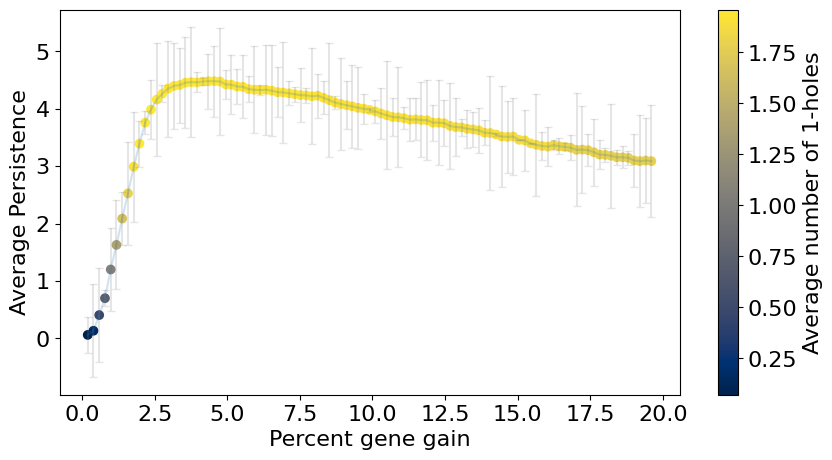

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(1, 1))
# Generar los tamaños de la ganancia de genes como eje x
gene_gain_sizes = np.arange(1, 100)
percentange_gene=gene_gain_sizes/505*100
plt.figure(figsize=(10, 5))
plt.scatter(percentange_gene, mean_persistences, marker='o',c=df_num_1_holes.mean(),cmap='cividis')
plt.errorbar(percentange_gene, mean_persistences, yerr=std_dev_persistences, ecolor='gray', alpha=0.2, capsize=3)
#plt.colorbar(label='Average number of 1-holes').ax.tick_params(labelsize=12)
colorbar = plt.colorbar(label='Average number of 1-holes')
# Modificar el tamaño de los números de la barra
colorbar.ax.tick_params(labelsize=16)
colorbar.set_label('Average number of 1-holes', fontsize=16)
plt.xlabel('Percent gene gain', fontsize=16)  # Adjust x-axis label size
plt.ylabel('Average Persistence', fontsize=16)  # Adjust y-axis label size
plt.xticks(fontsize=16)  # Adjust x-axis tick label size
plt.yticks(fontsize=16)  # Adjust y-axis tick label size
#plt.title('Variation in 1-hole persistence', fontsize=14)
#plt.grid(True)
plt.savefig("plots/gene_gain.svg", dpi=600)
#plt.savefig("plots/gene_gain.svg", dpi=600)
plt.show()

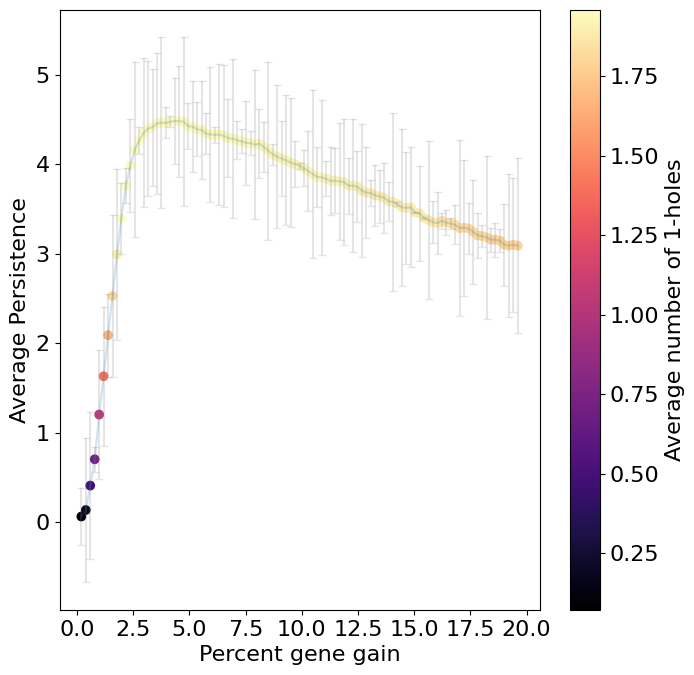

In [100]:
import matplotlib.pyplot as plt
import numpy as np



# Set square figure size
plt.figure(figsize=(6,6))  # Adjust size as needed

# Create the scatter plot with error bars
plt.scatter(percentange_gene, mean_persistences, marker='o', c=df_num_1_holes.mean(),cmap='magma')
plt.errorbar(percentange_gene, mean_persistences, yerr=std_dev_persistences, ecolor='gray', alpha=0.2, capsize=3)

# Adjust plot elements for clarity
plt.xlabel('Percent gene gain', fontsize=16)
plt.ylabel('Average Persistence', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
colorbar = plt.colorbar(label='Average number of 1-holes')
colorbar.ax.tick_params(labelsize=16)
colorbar.set_label('Average number of 1-holes', fontsize=16)

# Eliminate white borders by adjusting padding (experimental values)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save the plot as a square SVG with high DPI for better quality
plt.savefig("plots/gene_gain.svg", format='svg', dpi=600, bbox_inches='tight')
plt.savefig("plots/gene_gain.png", format='png', dpi=600, bbox_inches='tight')
#plt.close()  # Close the plot to avoid memory issues


In [ ]:

df_average_persistences.describe()

In [ ]:
df_num_1_holes.describe()


In [84]:
type(experiments_results[1]['population'])


numpy.ndarray

In [ ]:
def plot_groups_vs_1_holes(population, max_num_groups, num_positions_to_change):
    num_groups_values = range(1, max_num_groups + 1)
    num_1_holes_list = []
    average_persistences = []

    for num_groups in num_groups_values:
        num_1_holes, persistences = analyze_population(population, num_groups, 3, num_positions_to_change)
        num_1_holes_list.append(num_1_holes)
        average_persistence = sum(persistences) / len(persistences) if persistences else 0
        average_persistences.append(average_persistence)

    # Crear la gráfica
    plt.scatter(num_groups_values, num_1_holes_list, c=average_persistences, cmap='cividis')
    plt.colorbar(label='Average Persistence')
    plt.xlabel('Number of Groups')
    plt.ylabel('Number of 1-Holes')
    plt.xticks(fontsize=16)  # Adjust x-axis tick label size
    plt.yticks(fontsize=16)  # Adjust y-axis tick label size
    #plt.title('1-Holes and Persistence across Different Group Numbers')
    plt.savefig("plots/numbers_groups.svg", dpi=600)
    #plt.savefig("plots/numbers_groups.png", dpi=600)
    plt.show()


In [ ]:
### 2. Graficando los Resultados

# Calcular las medias y varianzas
means_num_1_holes = [np.mean(holes) for holes in total_num_1_holes]
variances_persistences = [np.var(pers) for pers in total_persistences]

# Configurar los gráficos
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Position Changes')
ax1.set_ylabel('Mean of 1-holes', color=color)
ax1.plot(range(1, 100), means_num_1_holes, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Variance of Persistences', color=color)
ax2.plot(range(1, 100), variances_persistences, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Analysis of Genetic Populations")
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import multiprocessing
# from functools import partial

# # Definir la función que procesa cada semilla
# def process_seed(seed, num_genes, mutation_probability, num_generations, num_offspring, percentage_ones):
#     print(f"Procesando semilla {seed}...")
#     population, population_genome_history = create_population(num_genes, mutation_probability, num_generations, num_offspring, percentage_ones, seed)
#     population = np.array(population)
#     num_1_holes_list = []
#     average_persistences = []
#     num_positions_changes = range(1, 100)
#     for num in num_positions_changes:
#         num_1_holes, persistences = analyze_population(population, 1, 3, num)
#         num_1_holes_list.append(num_1_holes)
#         average_persistences.append(sum(persistences) / len(persistences) if persistences else 0)
#     return num_1_holes_list, average_persistences

# # Definir el proceso principal
# def main():
#     num_genes = 505
#     mutation_probability = 1 / num_genes
#     num_generations = 7
#     num_offspring = 2
#     percentage_ones = 0.25
#     seeds_range = range(40, 42)  # Por ejemplo, de 40 a 41

#     # Crear un objeto partial para la función process_seed
#     func = partial(process_seed, num_genes=num_genes, mutation_probability=mutation_probability, 
#                    num_generations=num_generations, num_offspring=num_offspring, percentage_ones=percentage_ones)

#     # Crear un pool de procesos
#     with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
#         results = pool.map(func, seeds_range)

#     # Resultados
#     total_num_1_holes = [[] for _ in range(99)]  # 99 porque range(1,100) tiene 99 elementos
#     total_persistences = [[] for _ in range(99)]
    
#     for num_1_holes_list, average_persistences in results:
#         for i in range(99):
#             total_num_1_holes[i].append(num_1_holes_list[i])
#             total_persistences[i].append(average_persistences[i])

#     # Calcular las medias y varianzas
#     means_num_1_holes = [np.mean(holes) for holes in total_num_1_holes]
#     variances_persistences = [np.var(pers) for pers in total_persistences]

#     # Graficar los resultados
#     fig, ax1 = plt.subplots()

#     color = 'tab:red'
#     ax1.set_xlabel('Position Changes')
#     ax1.set_ylabel('Mean of 1-holes', color=color)
#     ax1.plot(range(1, 100), means_num_1_holes, color=color)
#     ax1.tick_params(axis='y', labelcolor=color)

#     ax2 = ax1.twinx()
#     color = 'tab:blue'
#     ax2.set_ylabel('Variance of Persistences', color=color)
#     ax2.plot(range(1, 100), variances_persistences, color=color)
#     ax2.tick_params(axis='y', labelcolor=color)

#     fig.tight_layout()
#     plt.title("Analysis of Genetic Populations")
#     plt.show()

# if __name__ == "__main__":
#     main()
